In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 63.5 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import ProgressBar

In [3]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
mnist_full = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.10MB/s]


In [5]:
train_size = int(len(mnist_full)*0.7)
val_size = len(mnist_full) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_full, [train_size, val_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [34]:
class CNN(L.LightningModule):
  def __init__(self):
    hidden_units = 64
    super().__init__()
    self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(0.6),
            nn.Linear(128 * 3 * 3, hidden_units),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_units, 10)
        )

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    preds = torch.argmax(logits, dim=1)
    accuracy = torch.sum(preds == y).item()/len(y)
    self.log("train_loss", loss)
    self.log("train_acc", accuracy, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x,y = batch
    logits = self(x)
    loss = F.cross_entropy(logits,y)
    preds = torch.argmax(logits, dim=1)
    accuracy = torch.sum(preds==y).item()/len(y)
    self.log("train_loss", loss)
    self.log("train_acc", accuracy, prog_bar=True)

  def test_step(self, batch, batch_idx):
    x,y = batch
    logits = self(x)
    loss = F.cross_entropy(logits,y)
    preds = torch.argmax(logits, dim=1)
    accuracy = torch.sum(preds==y).item()/len(y)
    self.log('test_loss', loss, prog_bar=True)
    self.log('test_acc', accuracy, prog_bar=True)
    self.test_preds.append(preds.cpu().numpy())
    self.test_labels.append(y.cpu().numpy())

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

  def on_test_epoch_start(self):
    self.test_preds = []
    self.test_labels = []

  # def on_test_epoch_end(self):
  #   preds = np.concatenate(self.test_preds)
  #   labels = np.concatenate(self.test_labels)
  #   conf_matrix = confusion_matrix(labels, preds)

In [36]:
model = CNN()

In [37]:
trainer = L.Trainer(max_epochs=5, logger = L.loggers.TensorBoardLogger('logs/', name = 'mnist_model'))

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [38]:
from IPython.core.display import ProgressBar
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ Sequential │  167 K │ train │     0 │
└───┴───────┴────────────┴────────┴───────┴───────┘

Trainable params: 167 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 167 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [39]:
trainer.test(model,test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9918000102043152     │
│         test_loss         │    0.02538783848285675    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.02538783848285675, 'test_acc': 0.9918000102043152}]

In [40]:
# trainer.test(model, test_loader)
preds = np.concatenate(model.test_preds)
labels = np.concatenate(model.test_labels)
conf_matrix = confusion_matrix(labels, preds)
print(conf_matrix)

[[ 972    0    1    0    0    0    4    1    2    0]
 [   0 1125    2    2    0    1    1    2    2    0]
 [   1    0 1025    1    0    0    1    3    1    0]
 [   0    0    0 1006    0    3    0    0    1    0]
 [   0    0    0    0  971    0    0    0    3    8]
 [   0    0    0    3    0  886    1    1    0    1]
 [   1    2    0    0    1    2  950    0    2    0]
 [   0    1    4    0    0    0    0 1018    1    4]
 [   1    0    1    1    0    0    0    1  968    2]
 [   0    0    0    0    2    2    0    2    6  997]]


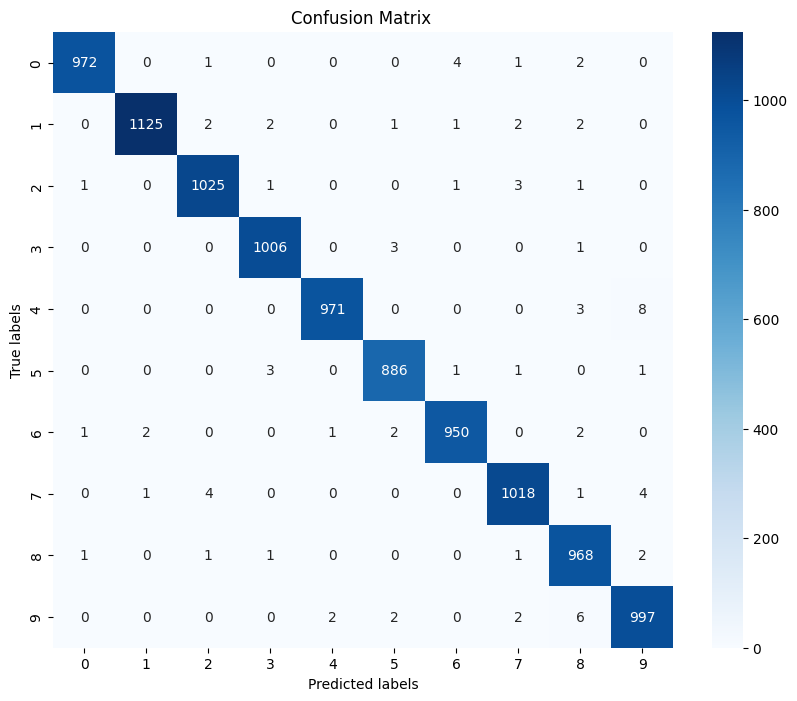

In [41]:
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', cbar = True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix ')

# Show the plot
plt.show()